In [3]:
import tensorflow as tf
import os
import numpy as np
from tensorflow.keras import layers, models

In [4]:
IMG_SIZE = 256
BATCH_SIZE = 32
EPOCHS = 20
CHANNELS = 3
INPUT_SHAPE = (BATCH_SIZE, IMG_SIZE, IMG_SIZE, CHANNELS)

In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory('/content/drive/MyDrive/Colab Notebooks/dataset (1)', 
                                                              shuffle=True, 
                                                              image_size=(IMG_SIZE, IMG_SIZE), 
                                                              batch_size=BATCH_SIZE)

Found 3585 files belonging to 11 classes.


In [6]:
class_names = dataset.class_names
print(class_names)

['Biryani', 'Chole-Bhature', 'Jalebi', 'Kofta', 'Naan', 'Paneer-Tikka', 'Pani-Puri', 'Pav-Bhaji', 'Vadapav', 'dal', 'dosa']


In [7]:
len(dataset)

113

## exploring images

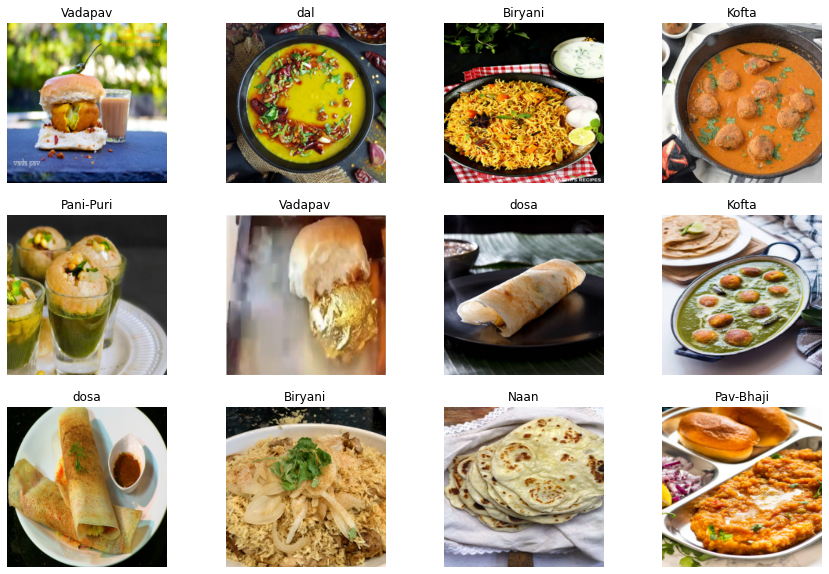

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.axis("off")
        plt.title(class_names[label_batch[i]])

## creating traning and test data

In [9]:
def train_test_split(ds, train_split=0.7, val_split=0.1, test_split=0.2, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(ds_size * train_split)
    val_size = int(ds_size * val_split)
    
    train_ds = ds.take(train_size)
    valid_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, valid_ds, test_ds

In [10]:
train_ds, valid_ds, test_ds = train_test_split(dataset)
print(len(train_ds), len(valid_ds), len(test_ds))

79 11 23


In [11]:
# creating resize and rescale layer
resize_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [12]:
## building model
model = models.Sequential([
    resize_rescale,
    layers.Conv2D(32, (3,3), activation='relu', input_shape=INPUT_SHAPE),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    layers.Dropout(0.2), 
    
    layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(len(class_names), activation='softmax')
])

model.build(input_shape=INPUT_SHAPE)

model.compile(optimizer='adam',
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
             metrics=['accuracy'])

In [13]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 128)       36992     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 128)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [14]:
history = model.fit(train_ds, epochs=EPOCHS, validation_data=valid_ds, batch_size=BATCH_SIZE, verbose=1)

Epoch 1/20
79/79 [==============================] - 684s 390ms/step - loss: 2.1722 - accuracy: 0.2421 - val_loss: 2.0827 - val_accuracy: 0.2500
Epoch 2/20
79/79 [==============================] - 48s 383ms/step - loss: 1.9327 - accuracy: 0.3414 - val_loss: 2.0783 - val_accuracy: 0.3239
Epoch 3/20
79/79 [==============================] - 47s 379ms/step - loss: 1.8732 - accuracy: 0.3790 - val_loss: 1.8477 - val_accuracy: 0.3835
Epoch 4/20
79/79 [==============================] - 47s 383ms/step - loss: 1.7796 - accuracy: 0.4025 - val_loss: 1.6858 - val_accuracy: 0.4233
Epoch 5/20
79/79 [==============================] - 47s 379ms/step - loss: 1.6616 - accuracy: 0.4397 - val_loss: 1.6358 - val_accuracy: 0.4375
Epoch 6/20
79/79 [==============================] - 48s 381ms/step - loss: 1.5315 - accuracy: 0.4818 - val_loss: 1.4594 - val_accuracy: 0.4858
Epoch 7/20
79/79 [==============================] - 47s 376ms/step - loss: 1.4557 - accuracy: 0.5298 - val_loss: 1.2926 - val_accuracy: 0.571

In [15]:
model.evaluate(test_ds)

23/23 [==============================] - 19s 54ms/step - loss: 0.2262 - accuracy: 0.9280


[0.22622574865818024, 0.92798912525177]

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'traning vs validation accuracy')

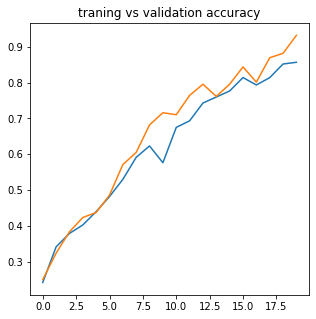

In [17]:
plt.figure(figsize=(5, 5))
plt.plot(range(EPOCHS), acc, label="accuracy")
plt.plot(range(EPOCHS), val_acc, label="val_accuracy")
plt.title("traning vs validation accuracy")

In [18]:
model.save('model.h5')